In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

def planck(wav, T, N, z_pec=0.): #blackbody
    wav = wav*(1+z_pec)
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def lum_dist(p, psig, beta, dbeta, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    theta = 2*np.sqrt(p[1]*10**(7)/np.pi)
    dtheta = 1/np.sqrt(p[1])*np.sqrt(10**(7)/np.pi)*psig[1]

    v = beta*c/2; dv = dbeta*c/2 #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t; dr = dv*t 
    
    D = r/theta*2# factor of 2 
    dD = ( (r/theta**2*2*dtheta)**2 + (dr/theta*2)**2 )**(1/2)

    D_mpc = D*(3.2408e-23)
    dD_mpc = dD*(3.2408e-23)
    
    return D_mpc, dD_mpc


In [3]:
reset_plt(18,25)
path = '.\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)
x = np.loadtxt(path+'/'+files[0])
exc_reg = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9940) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500) & \
          (~((x[:,0] > 3000) & (x[:,0] < 4500))) & (~((x[:,0] > 7000) & (x[:,0] < 8500))) #sr absorbtion feature


In [7]:
#unc = []
#for i,j in enumerate(x[:,0]): 
#    unc.append(np.std(x[i-3:i+3,1][x[i-3:i+3,1]==x[i-3:i+3,1]]) )

[5.14920774e+03 5.06364435e-30] [7.36532908e-01 2.65155328e-33]


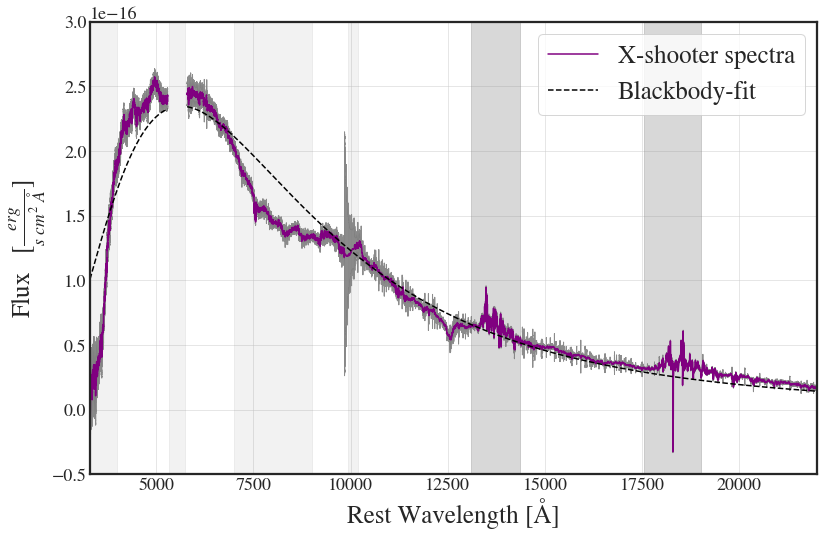

In [4]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')
p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], sigma = x[:,3][exc_reg],
                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)
psig = np.sqrt(np.diagonal(cov)) #*40

print(p, psig)

plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p), ls='--', color='k', label='Blackbody-fit')
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)


plt.xlim(3300, 22000), plt.ylim(-5*10**(-17),3*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.legend(frameon=True)
plt.tight_layout()
#plt.savefig('Pictures/13-12-2021-1.png', dpi=300)

(3000.0, 22000.0)

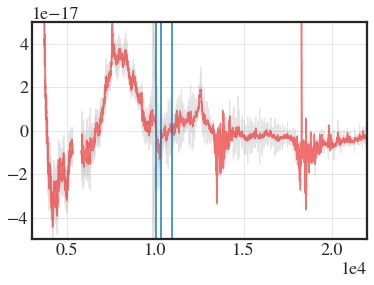

In [1342]:
plt.ylim(-5e-17,5e-17)
plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p)-x[:,1], color='red', alpha=0.5)
plt.fill_between(x[:,0], planck(x[:,0]*10**(-10),*p)-(x[:,1]-x[:,3]), 
                         planck(x[:,0]*10**(-10),*p)-(x[:,1]+x[:,3]), 
                 color='grey', alpha=0.2)

plt.axvline(10327), plt.axvline(10915), plt.axvline(10040)
plt.xlim(3000, 22000)

In [1503]:
unc = np.array(unc)

In [1684]:
x = np.loadtxt(path+'/'+files[3])
exc_reg = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9940) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500) & \
          (~((x[:,0] > 3000) & (x[:,0] < 4500))) & (~((x[:,0] > 7000) & (x[:,0] < 12000))) #sr absorbtion feature
p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], sigma = x[:,3][exc_reg],
                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)
psig = np.sqrt(np.diagonal(cov)) #*40

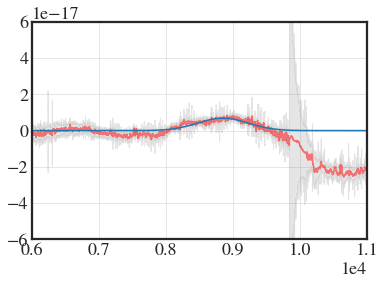

In [1685]:
plt.ylim(-6e-17,6e-17)
plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p)-x[:,1], color='red', alpha=0.5)
plt.fill_between(x[:,0], planck(x[:,0]*10**(-10),*p)-(x[:,1]-x[:,3]), 
                         planck(x[:,0]*10**(-10),*p)-(x[:,1]+x[:,3]), 
                 color='grey', alpha=0.2)

#plt.axvline(10327), plt.axvline(10915), plt.axvline(10040)
plt.xlim(6000, 11000)

def gaussian(x,N,mu,sig):
    return N*np.exp(-(x-mu)**2/(2*sig**2))

p1,p1_cov = curve_fit(gaussian, x[:,0][(x[:,0]>6000) & (x[:,0]<11000)],
        planck(x[:,0][(x[:,0]>6000) & (x[:,0]<11000)]*10**(-10),*p)-x[:,1][(x[:,0]>6000) & (x[:,0]<11000)],
        sigma= x[:,3][(x[:,0]>6000) & (x[:,0]<11000)], p0 = [4e-17, 8000, 1000], absolute_sigma=False)
plt.plot(x[:,0], gaussian(x[:,0],*p1))
p1sig=np.sqrt(np.diagonal(p1_cov))
#plt.savefig('13-12-21-gaussian.png', dpi=300)

In [1686]:
10300/p1[1]-1, 10500/p1[1]**2 * p1sig[1]

(0.1638456192122466, 0.000617289448007624)

In [1687]:
#my beta using 10327 SrII line
beta  = np.array([0.2853 , 0.2303,0.1913,0.1885,0.1658] )
dbeta = np.array([0.0002, 0.0005,0.0003,0.0004,0.0010] )*np.sqrt(51) #+ 0.001

((0.1, 0.3), (0.0, 5.0))

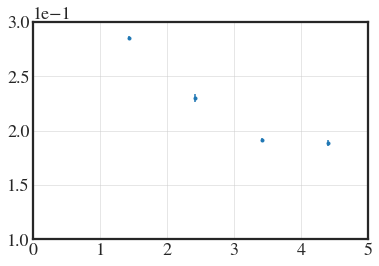

In [1673]:
plt.errorbar([1.43, 2.42, 3.41, 4.40], beta[:-1], yerr=dbeta[:-1], fmt='.')
plt.ylim(0.1, 0.3), plt.xlim(0., 5)

In [5]:
#Nature-Selsing
beta =  [0.275 , 0.24, 0.19, 0.10]
dbeta = [0.005 , 0.005,0.01, 0.03]

In [1547]:
theta = 2*np.sqrt(p[1]*10**(7)/np.pi)
dtheta = 1/np.sqrt(p[1])*np.sqrt(10**(7)/np.pi)*psig[1]
print(theta,dtheta)

v = 0.23*c / 2 #factor of 2
t = 1.43 * (3600*24)
r = v*t

D = r/theta*2# factor of 2 
dD = r/theta**2*2*dtheta

D_mpc = D*(3.2408e-23)
dD_mpc = dD*(3.2408e-23)

print(D_mpc, dD_mpc)

1.668338860131253e-11 1.0403336649955824e-15
16.56024795120244 0.0010326549273661724


### For each Epoch

Temp =  5133.855647946198 0.7143033776836484
Norm =  5.260307144326307e-30 2.7263197848224458e-33


(40.36410691852498, 0.7339673910032235)

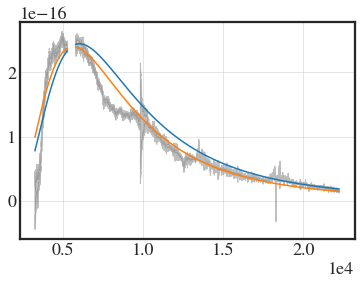

In [6]:
x = np.loadtxt(path+'/'+files[0])
exc_reg = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9940) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500) & \
          (~((x[:,0] > 3000) & (x[:,0] < 4500))) & (~((x[:,0] > 7000) & (x[:,0] < 9000))) #sr absorbtion feature


y = planck(x[:,0]*10**(-10), 4800, (7.5*10**(-30)) )
plt.plot(x[:,0], y )
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 label='X-shooter spectra', color='grey', alpha=0.5)

p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], sigma = x[:,3][exc_reg],
                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)
psig = np.sqrt(np.diagonal(cov)) #*40
plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p) )
print('Temp = ',p[0],psig[0])
print('Norm = ',p[1],psig[1])
#print('z = '   ,p[2],psig[2])

d1,dd1 = lum_dist(p, psig, beta[0], dbeta[0], n_days=1.43)
d1,dd1

Temp =  3688.2774677968287 1.1980856416165395
Norm =  1.1010133841353712e-29 1.8607697192520462e-32
41.20619150358872 0.8584774822613611


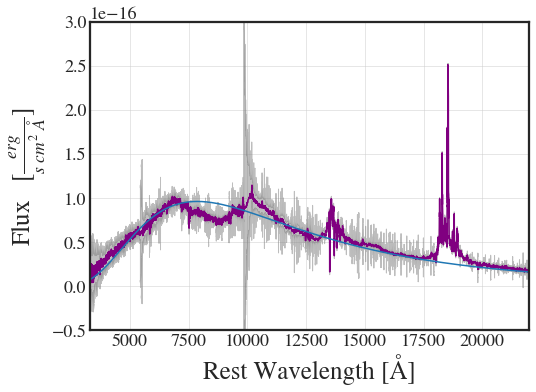

In [7]:
fig,ax = plt.subplots(figsize=(8,6))

x = np.loadtxt(path+'/'+files[1])
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')
exc_reg = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9940) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500) & \
          (~((x[:,0] > 3000) & (x[:,0] < 4500))) & (~((x[:,0] > 7000) & (x[:,0] < 9000))) #sr absorbtion feature

plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 label='X-shooter spectra', color='grey', alpha=0.5)

p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], p0 = [3000, 5*10**(-30)])
plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p) )
print('Temp = ',p[0],np.sqrt(cov[0,0]))
print('Norm = ',p[1],np.sqrt(cov[1,1]))
#print('z = ',p[2],np.sqrt(cov[2,2]))
d2,dd2 = lum_dist(p, psig, beta[1], dbeta[1], n_days=2.42)
print(d2, dd2)

plt.xlim(3300, 22000), plt.ylim(-5*10**(-17),3*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
plt.tight_layout()
#plt.savefig('Pictures/13-12-2021-2.png', dpi=300)

Temp =  3134.3663386112635 1.3814763401506407
Norm =  1.699746393178693e-29
36.99543037000577 1.947130174670587


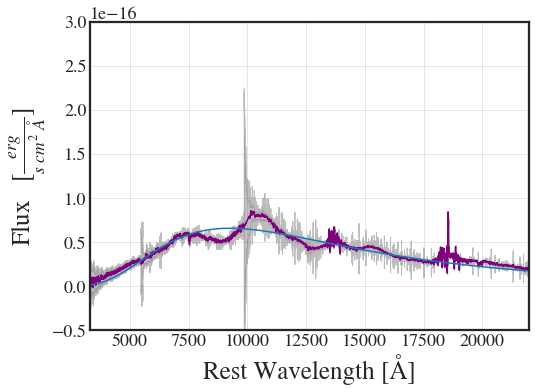

In [20]:
fig,ax = plt.subplots(figsize=(8,6))

x = np.loadtxt(path+'/'+files[2])
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')
exc_reg = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9940) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500) & \
          (~((x[:,0] > 3000) & (x[:,0] < 4500))) & (~((x[:,0] > 7500) & (x[:,0] < 9000))) #sr absorbtion feature


plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 label='X-shooter spectra', color='grey', alpha=0.5)

p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], p0 = [3000, 5*10**(-30)])
plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p) )
print('Temp = ',p[0],np.sqrt(cov[0,0]))
print('Norm = ',p[1])
#print('Norm = ',p[2])
d3,dd3 = lum_dist(p, psig, beta[2], dbeta[2], n_days=3.41)
print(d3, dd3)

plt.xlim(3300, 22000), plt.ylim(-5*10**(-17),3*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
plt.tight_layout()
#plt.savefig('Pictures/13-12-2021-3.png', dpi=300)

Temp =  2823.4192441460327
Norm =  2.1860415534006945e-29
22.154177861140393 6.646253501917889


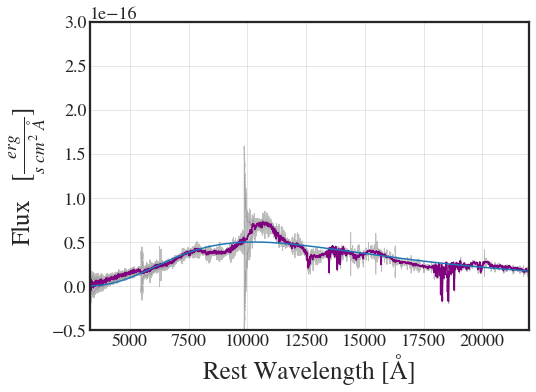

In [21]:
fig,ax = plt.subplots(figsize=(8,6))

x = np.loadtxt(path+'/'+files[3])
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')
exc_reg = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9940) & (x[:,0] < 10300))) & \
          (x[:,0] > 3400) & (x[:,0] < 22500) & \
          (~((x[:,0] > 3000) & (x[:,0] < 4500))) & (~((x[:,0] > 7000) & (x[:,0] < 9000))) #sr absorbtion feature


plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 label='X-shooter spectra', color='grey', alpha=0.5)

p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], p0 = [3000, 5*10**(-30)])
plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p) )
print('Temp = ',p[0])
print('Norm = ',p[1])
#print('Norm = ',p[2])

plt.xlim(3300, 22000), plt.ylim(-5*10**(-17),3*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
plt.tight_layout()

d4,dd4 = lum_dist(p, psig, beta[3], dbeta[3], n_days=4.40)
print(d4, dd4)


In [10]:
d1, dd1

(40.36410691852498, 0.7339673910032235)

distance_modulus = 39.52190959737316 pm 0.9096335871144007


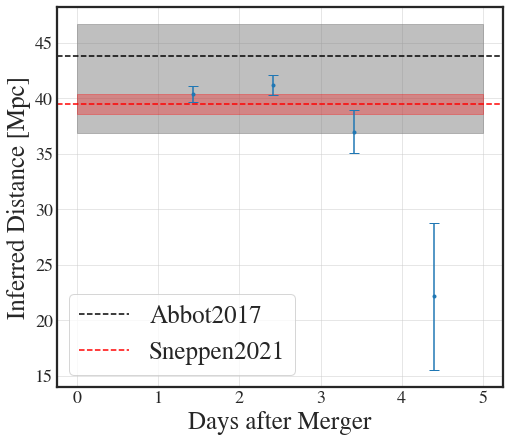

In [26]:
plt.figure(figsize=(8,7))
plt.errorbar( [1.43, 2.42, 3.41, 4.40], [d1,d2,d3,d4], yerr = np.array([dd1,dd2,dd3,dd4]), 
             fmt='.', capsize=5 )
plt.xlabel('Days after Merger'), plt.ylabel('Inferred Distance [Mpc]')

d_best = np.mean([d1,d2,d3])
ddbest = np.std([d1,d2,d3])/np.sqrt(4)
d_weight = np.sum( [d1,d2,d3]*np.array([dd1,dd2,dd3])**2/np.sum(np.array([dd1,dd2,dd3])**2) )

print('distance_modulus =', d_best,'pm', ddbest)
plt.axhline(43.8, ls='--', color='k', label='Abbot2017')
plt.fill_between(np.arange(0,6), (36.9)*np.ones(6), (46.7)*np.ones(6), 
                 color='grey', alpha = 0.5)


#plt.ylim(30,50), plt.xlim(0,5), 
plt.axhline(d_best, ls='--', color='red', label='Watson2017')
plt.fill_between(np.arange(0,6), (d_best-ddbest)*np.ones(6), (d_best+ddbest)*np.ones(6), 
                 color='red', alpha = 0.3)

plt.legend(frameon=True)

#plt.axhline(0.00968*c*10**(-3)/H0_shoes, ls='--', alpha=0.4)
#plt.axhline(0.00968*c*10**(-3)/H0_planck, ls='--', color='red', alpha=0.4)

#plt.savefig('Pictures/14-12-2021-2.png', dpi=300)

In [27]:
H0 = 0.0098*c*(10**(-3))/d1
dH0 = ((0.0098*c*(10**(-3))/d1**2*dd1)**2 + (0.0005*c*(10**(-3))/d1)**2 )**(1/2)
H0, dH0

(72.83698871213464, 3.945135139090972)

In [28]:
H0 = 0.0098*c*(10**(-3))/d_weight
dH0 = ((0.0098*c*(10**(-3))/d_weight**2*ddbest)**2 + (0.0005*c*(10**(-3))/d_weight)**2 )**(1/2)
H0, dH0

(77.43766251219941, 4.364849172785472)

In [1556]:
H0 = 0.0098*c*(10**(-3))/np.array([d1,d2,d3,d4])
np.mean(H0), np.std(H0)/np.sqrt(4)
#dH0 = 0.0098*c*(10**(-3))/np.array([d1,d2,d3,d4])**2*ddbest

(72.7417950623297, 2.18171609537968)

In [1605]:
166000/c

0.0005533333333333333

In [1154]:
H0 = 0.0098*c*(10**(-3))/d_best
dH0 = 0.0098*c*(10**(-3))/d_best**2*ddbest
H0, dH0

(70.94681477717756, 1.908968611146388)

### Comparison Cosmology

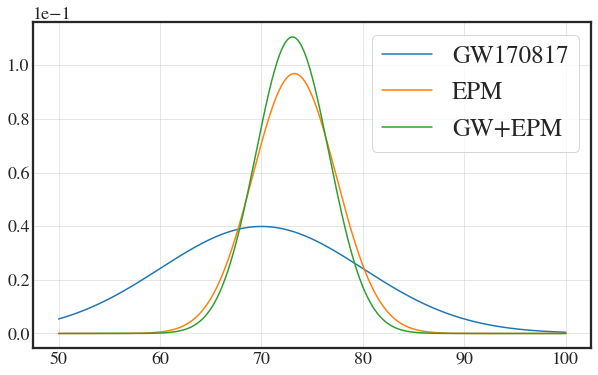

In [1688]:
def gaussian_norm(x,mu,sig):
    return 1/np.sqrt(2*np.pi*sig**2) * np.exp(-(x-mu)**2/(2*sig**2))
x_c = np.linspace(50,100,1000)

plt.figure(figsize=(10,6))
#plt.ylim(0,0.8), plt.yscale('log')
plt.plot(x_c, gaussian_norm(x_c,*[70,10]), label='GW170817')
plt.plot(x_c, gaussian_norm(x_c,*[H0,dH0]), label='EPM')

plt.plot(x_c, gaussian_norm(x_c,*[72.4,7.5])*gaussian_norm(x_c,*[H0,dH0])/
         np.sum(gaussian_norm(x_c,*[72.4,7.5])*gaussian_norm(x_c,*[H0,dH0])*(x_c[1]-x_c[0])), 
         label='GW+EPM')
#plt.plot(x_c, gaussian_norm(x_c,*[H0_planck,dH0_planck]), label='GW170817')
plt.legend(frameon=True); 

0.035261715964223714

In [1177]:
H0_shoes, dH0_shoes   = 73.04, 1.04
H0_planck, dH0_planck = 67.36, 0.54

(H0-H0_shoes)/np.sqrt(dH0_shoes**2+dH0**2), (H0-H0_planck)/np.sqrt(dH0_planck**2+dH0**2)

(-0.6436800302472746, 0.43940131825041534)

####  Fitting a blackbody

In [ ]:
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return intensity

y = planck(x[:,0]*10**(-10), 5000)
plt.plot(x[:,0]*10**(-10), y*10**(-29))

### All Epochs

In [48]:
time

array([1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4, 8.4, 9.4])

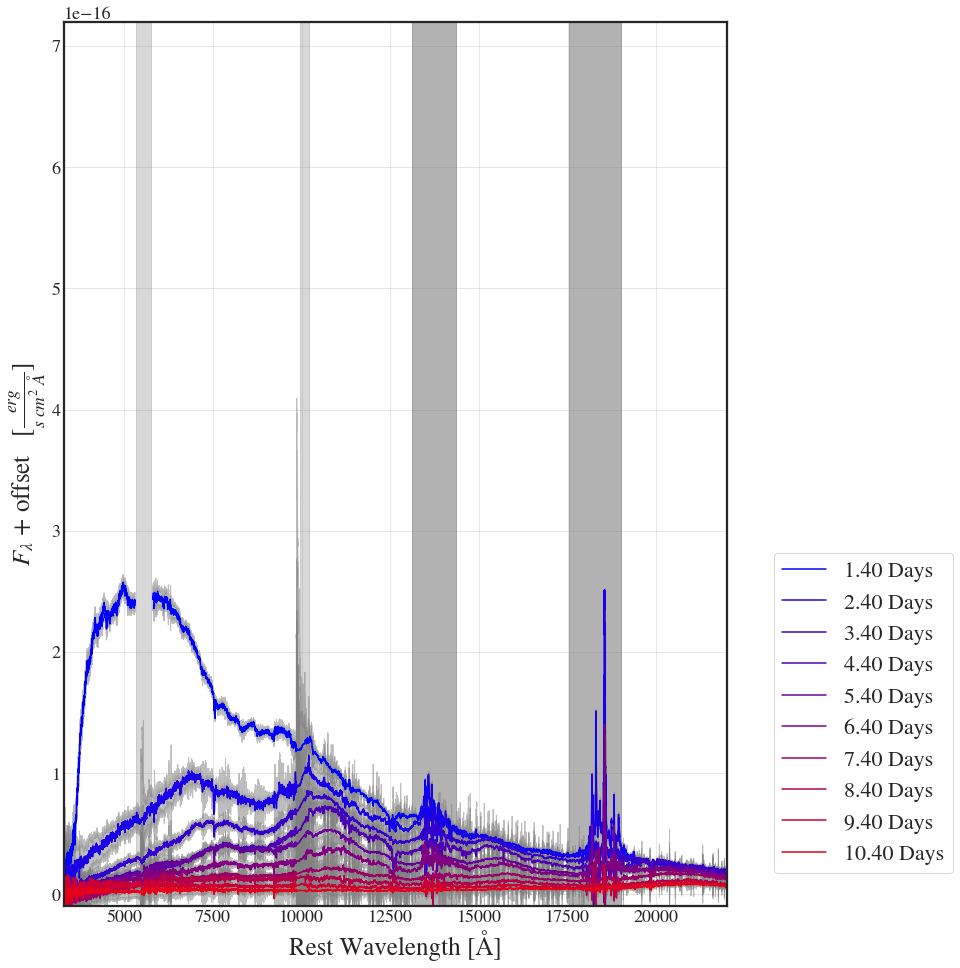

In [90]:
fig,ax = plt.subplots(figsize=(14,14))
color_list = [[i/10, 0 , 1-i/10] for i in range(10)]
shift = 0*np.arange(10)[::-1]*5e-17
time = np.arange(1,11)+0.4

for i in range(len(files)): 
    x = np.loadtxt(path+'/'+files[i])
    plt.plot(x[:,0], x[:,1]+shift[i], color=color_list[i], label=r'{:.2f} Days'.format(time[i]))
    #plt.fill_between(x[:,0], x[:,1]-x[:,3]+shift[i], x[:,1]+x[:,3]+shift[i], 
    #                 color='grey', alpha=0.5)
    
plt.xlim(3300, 22000), plt.ylim(-1*10**(-17),7.2*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'$F_\lambda$ + offset   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.6 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.6 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.3   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.3  )

plt.legend(frameon=True, fontsize=22,bbox_to_anchor=(1.07,0.4), borderaxespad=0)
plt.tight_layout()
#plt.savefig('Pictures/first_spectra_2.png', dpi=300)

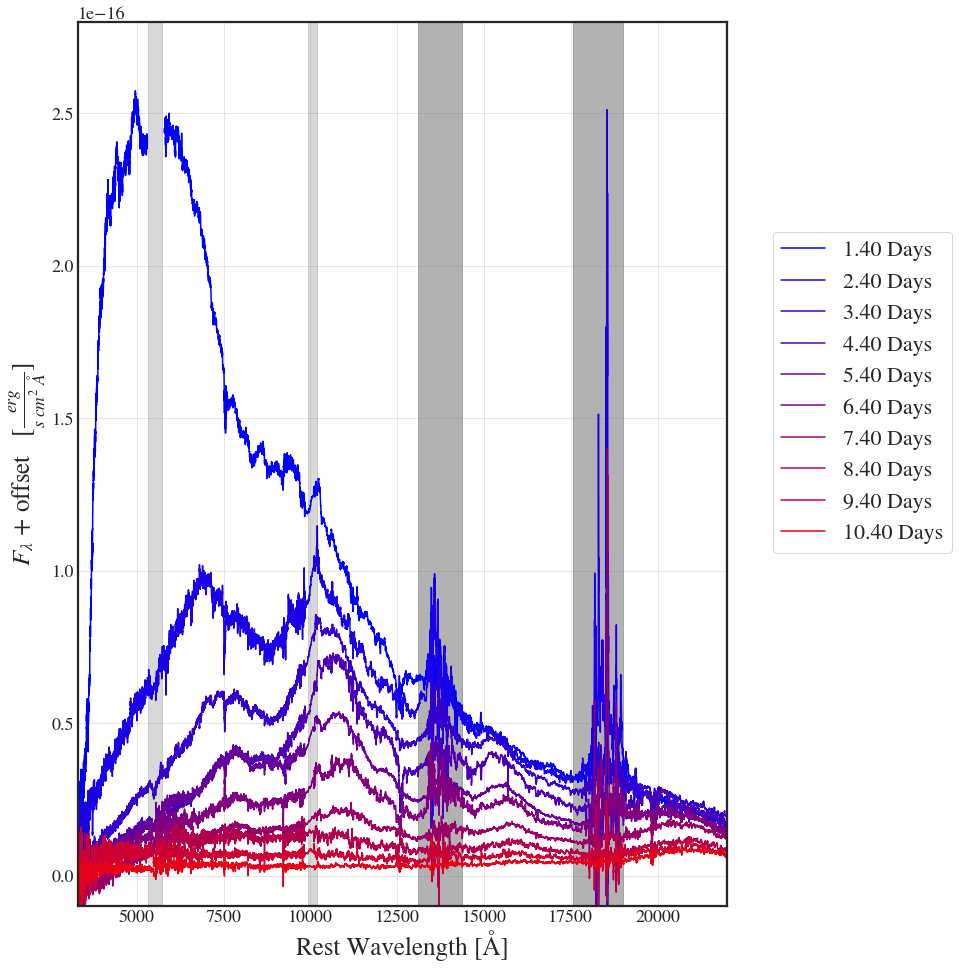

In [91]:
fig,ax = plt.subplots(figsize=(14,14))
color_list = [[i/10, 0 , 1-i/10] for i in range(10)]
shift = 0*np.arange(10)[::-1]*5e-17
time = np.arange(1,11)+0.4

for i in range(len(files)): 
    x = np.loadtxt(path+'/'+files[i])
    plt.plot(x[:,0], x[:,1]+shift[i], color=color_list[i], label=r'{:.2f} Days'.format(time[i]))
    #plt.fill_between(x[:,0], x[:,1]-x[:,3]+shift[i], x[:,1]+x[:,3]+shift[i], 
    #                 color='grey', alpha=0.5)
    
plt.xlim(3300, 22000), plt.ylim(-1*10**(-17),2.8*10**(-16))
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'$F_\lambda$ + offset   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.6 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.6 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.3   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [12*10**(-16), 12*10**(-16)], color='grey', alpha=0.3  )

plt.legend(frameon=True, fontsize=22,bbox_to_anchor=(1.07,0.4), borderaxespad=0)
plt.tight_layout()
#plt.savefig('Pictures/first_spectra_2.png', dpi=300)

### Minuit

<ipython-input-1084-246bc8a0c71e>:9: InitialParamWarning: Parameter z_pec does not have neither initial value nor limits.
  minuit0 = Minuit(chi2fit, T = 5300, N = 5*10**(-30))
<ipython-input-1084-246bc8a0c71e>:9: InitialParamWarning: errordef is not given, defaults to 1.
  minuit0 = Minuit(chi2fit, T = 5300, N = 5*10**(-30))


  Model fit:  Prob(Chi2=406225.9, Ndof=53085) = 0.000000000000000
5205.970937064101 4.68025173179665e-08
4.79353826982774e-30 2.0600279788992374e-40


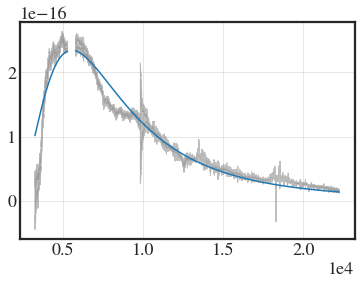

In [1084]:
from iminuit import Minuit    # The actual fitting tool, better than scipy's
import sys 
from scipy import stats

sys.path.append('../Completed Courses/Appstat2020/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH

chi2fit = Chi2Regression(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], x[:,3][exc_reg] )
minuit0 = Minuit(chi2fit, T = 5300, N = 5*10**(-30))

minuit0.migrad();
chi2 = minuit0.fmin.fval
#Ndof = len(price[year<2003]) - len(minuit0.values)
Ndof = len(x[:,1]) - len(minuit0.values)
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:.15f}")
plt.plot( x[:,0], planck(x[:,0]*10**(-10), minuit0.values['T'], minuit0.values['N']), 
         label='Powerlaw Fit' )
print(minuit0.values['T'], minuit0.errors['T'])
print(minuit0.values['N'], minuit0.errors['N'])

plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 label='X-shooter spectra', color='grey', alpha=0.5)